### Purpose

This Jupyter notebook contains pilot data exploring the relationship between PM<sub>2.5</sub> and cardiopulmonary hospital ED or urgent care visits. I am using Washington state CHARS data from 2012. I have time-stratified case-crossover designs. I am evaluating PM<sub>2.5</sub>'s effect on CVD events using a non-linear distributed lag model to look at varying levels of PM<sub>2.5</sub> .

Things I want to do: check distribution, try out a couple interaction models in case-crossover and time-series, assemble cohort to get some numbers.

Starting by loading R libraries necessary for project.

In [30]:
# load libraries
library(tidyverse)
library(survival) 
library(dlnm)

This is dlnm 2.3.4. For details: help(dlnm) and vignette('dlnmOverview').


Setting up a lagged function to work with dplyr.

In [10]:
# defining a lag function
funlag <- function(var, n=7){
  var <- enquo(var)
  indices <- seq_len(n)
  map( indices, ~quo(lag(!!var, !!.x)) ) %>% 
    set_names(sprintf("%s_lag%d", rlang::quo_text(var), indices))
}

Importing PM<sub>2.5</sub> data and CVD case-crossover data.

In [179]:
# pm2.5 estimates
pm <- read_csv("../../data/pm_data/zip_pm_to_merge_with_chars.csv") %>% 
    na.omit() %>% 
      # make indicator variable
    mutate(gwr_smk0 = ifelse(geo_smk_pm> 0, 1, 0),
        gwr_smk5 = ifelse(geo_smk_pm> 5, 1, 0),
        gwr_smk10 = ifelse(geo_smk_pm > 10, 1, 0),
        gwr_smk15 = ifelse(geo_smk_pm > 15, 1, 0),
        gwr_smk20 = ifelse(geo_smk_pm > 20, 1, 0),
        gwr_10unit = geo_wt_pm/10,
        temp_f = (wrf_temp * 9/5) -459.67)  %>% 
    # create lagged gwr and temp variables 
    arrange(ZIPCODE, date)  %>% 
    group_by(ZIPCODE)  %>% 
    mutate(., !!!funlag(geo_wt_pm, 5), !!!funlag(temp_f, 5))

Parsed with column specification:
cols(
  ZIPCODE = col_integer(),
  date = col_date(format = ""),
  wrf_pm = col_double(),
  wrf_nf_pm = col_double(),
  wrf_smk_pm = col_double(),
  geo_wt_pm = col_double(),
  global_reg_pm = col_double(),
  krig_pm = col_double(),
  background_pm = col_double(),
  geo_smk_pm = col_double(),
  global_smk_pm = col_double(),
  krig_smk_pm = col_double(),
  wrf_temp = col_double(),
  wrf_pbl = col_double()
)


Observations: 72,939
Variables: 31
$ ZIPCODE        <int> 98001, 98001, 98001, 98001, 98001, 98001, 98001, 980...
$ date           <date> 2012-07-01, 2012-07-02, 2012-07-03, 2012-07-04, 201...
$ wrf_pm         <dbl> 15.522356, 24.683010, 9.995644, 22.184186, 28.518336...
$ wrf_nf_pm      <dbl> 8.152526, 12.227195, 11.435624, 24.655595, 25.920645...
$ wrf_smk_pm     <dbl> 7.369831e+00, 1.245582e+01, 0.000000e+00, 0.000000e+...
$ geo_wt_pm      <dbl> 3.892921, 5.960679, 4.915395, 11.612443, 16.902343, ...
$ global_reg_pm  <dbl> 4.752680, 7.310229, 5.321698, 12.291009, 17.505435, ...
$ krig_pm        <dbl> 3.868345, 5.923073, 4.899932, 11.593814, 16.890533, ...
$ background_pm  <dbl> 6.478359, 6.478359, 6.478359, 6.478359, 6.478359, 6....
$ geo_smk_pm     <dbl> 0.00000000, 0.00000000, 0.00000000, 5.13408339, 10.4...
$ global_smk_pm  <dbl> 0.000000000, 0.834305279, 0.000000000, 5.812649806, ...
$ krig_smk_pm    <dbl> 0.00000000, 0.00000000, 0.00000000, 5.11545501, 10.4...
$ wrf_temp       

In [297]:
# all cvd
cvd <- read_csv("../../data/health_data/cvd1_jul_to_oct_time_strat_casecross.csv") %>% 
    select(date:outcome) %>% 
    # join with pm data
    left_join(pm, by = c("ZIPCODE", "date")) %>% 
    # filter to complete case
    filter(!is.na(geo_wt_pm_lag5))

# respiratory
resp <- read_csv("../../data/health_data/resp1_jul_to_oct_time_strat_casecross.csv") %>% 
    select(date:outcome) %>% 
    # join with pm data
    left_join(pm, by = c("ZIPCODE", "date"))  %>% 
    # filter to complete case
    filter(!is.na(geo_wt_pm_lag5))

Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = ""),
  PATIENTID = col_integer(),
  cvd1 = col_integer(),
  ZIPCODE = col_integer(),
  COUNTYRES = col_character(),
  county = col_character(),
  ADM_TYPE = col_integer(),
  date_admit = col_date(format = ""),
  date_discharge = col_date(format = ""),
  length_stay = col_integer(),
  AGE = col_integer(),
  age_cat = col_integer(),
  sex_num = col_integer(),
  race_nhw = col_integer(),
  fips_county = col_character(),
  day = col_character(),
  day_admit = col_character(),
  season_admit = col_character(),
  season_smk = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = ""),
  PATIENTID = col_integer(),
  resp1 = col_integer(),
  ZIPCODE = col_integer(),
  COUNTYRES = col_character(),
  county = col_character(),
  ADM_TYPE = col_integer(),
  date_admit = col_date(format = ""),
  date_disc

### PM2.5 Distribution

Looking at the distribution of PM<sub>2.5</sub> values during this time. Mean is around 8.5 ug/m<sup>3</sup> and got as high as 269 ug/m<sup>3</sup>.


# A tibble: 1 x 4
  pm_mean pm_med pm_min pm_max
    <dbl>  <dbl>  <dbl>  <dbl>
1    8.46   6.20  0.558   269.


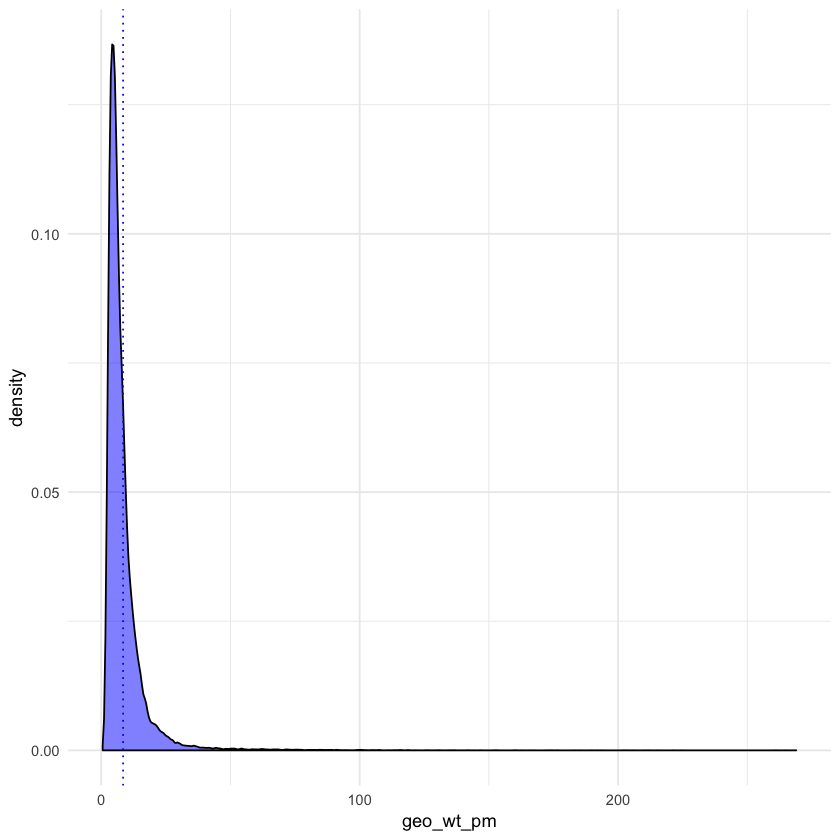

In [27]:
# find mean pm
pm_mean <- pm %>% 
    ungroup()  %>% 
    summarise(pm_mean = mean(geo_wt_pm), pm_med = median(geo_wt_pm),
            pm_min = min(geo_wt_pm), pm_max = max(geo_wt_pm))

print(pm_mean)
# plot mean pm
plot <- ggplot(data=pm, aes(x=geo_wt_pm)) +
  geom_density(fill = "blue", alpha = 0.5) +
  geom_vline(data = pm_mean, aes(xintercept=pm_mean),
             color = "blue", linetype = "dotted") +
  theme_minimal()
# print plot
print(plot)

Looking at the quintile of PM<sub>2.5</sub> distribution. I'd say anything over 20 ug/m<sup>3</sup> is going to be days impacted by wildfire smoke. I think it would be reasonable to look at the effects at 5, 10, 20, and 40 ug/m<sup>3</sup>

In [29]:
# finding every 5% of PM2.5 values by 
quantile(pm$geo_wt_pm, probs = seq(0,1, by=0.05))

0%         5%        10%        15%        20%        25%        30% 
  0.558000   2.625139   3.142908   3.547021   3.906000   4.255036   4.635325 
       35%        40%        45%        50%        55%        60%        65% 
  4.983709   5.359177   5.745327   6.196952   6.680040   7.243336   7.893000 
       70%        75%        80%        85%        90%        95%       100% 
  8.601454   9.477919  10.664000  12.292562  14.732373  20.203635 268.909750

### Association between PM<sub>2.5</sub> and Respiratory ED/urgent care visit 

Evaluating the same-day association between PM<sub>2.5</sub> and CVD ED event. 

Based on clogit model, looks like there is no association for same-day events.

In [298]:
# clogit model
mod <- clogit(outcome ~ gwr_10unit + temp_f + strata(PATIENTID), 
             data = resp)
# summary of model
summary(mod)

Call:
coxph(formula = Surv(rep(1, 165472L), outcome) ~ gwr_10unit + 
    temp_f + strata(PATIENTID), data = resp, method = "exact")

  n= 165472, number of events= 9425 

                coef exp(coef)  se(coef)      z Pr(>|z|)    
gwr_10unit  0.057971  1.059684  0.012430  4.664 3.10e-06 ***
temp_f     -0.005922  0.994095  0.001131 -5.238 1.63e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
gwr_10unit    1.0597     0.9437    1.0342    1.0858
temp_f        0.9941     1.0059    0.9919    0.9963

Rsquare= 0   (max possible= 0.275 )
Likelihood ratio test= 38.77  on 2 df,   p=4e-09
Wald test            = 40.46  on 2 df,   p=2e-09
Score (logrank) test = 40.71  on 2 df,   p=1e-09


### Respiratory Non-Linear Distributed Lag

Evaluating a distributed lag association over 5 days of exposure and at levels of 10, 20, 30, 40, 50 ug/m<sup>3</sup>. Starting by creating the lagged matrix of PM<sub>2.5</sub> and temperature.

In [377]:
# pm lag matrix
pm_lag_mat <- resp %>% 
    select(contains("geo_wt_pm")) %>% 
    as.matrix() 

# temp lag mat
temp_lag_mat <- resp %>% 
    select(contains("temp_f")) %>% 
    as.matrix()

head(pm_lag_mat)

geo_wt_pm,geo_wt_pm_lag1,geo_wt_pm_lag2,geo_wt_pm_lag3,geo_wt_pm_lag4,geo_wt_pm_lag5
7.011,16.887,9.742,4.116,5.051,3.757
8.886,8.066,12.528,15.557,14.364,10.988
5.089,8.061,5.773,8.473,6.982,3.883
4.447,8.563,7.151,5.168,3.640,3.490
6.943,6.743,6.899,4.579,4.644,5.574
6.260,4.969,4.628,8.068,8.276,9.797


Estimating the crossbasis. I'm going to try a 2 knot ns spline for the lag function with knots at lag day 2. I will model a 2 degrees of freedom spline for exposure response to PM<sub>2.5</sub>. I also fit a crossbasis for temperature, but the BIC fit suggested just adjusting for wrf_temp was a much better fit.

In [378]:
# crossbasis of pm
cb_pm <- crossbasis(pm_lag_mat, argvar = list(fun="ns", df = 2), lag = 5, 
                    arglag = list(fun="ns", knots = 2.5, intercept = T))

Running conditional logistic regression model with crossbasis of PM and temperature.

In [379]:
# clogit model
resp_dl_mod <- clogit(outcome ~ cb_pm + temp_f + strata(PATIENTID), data = resp)
BIC(resp_dl_mod)

[1] 53269.55

Estimating exposure/response and lag/response of relative odds of CVD event given PM exposure. Centering at 6 ug/m<sup>3</sup>, which is more or less the average/median.

In [380]:
# cross-basis prediction 
cb_pred <- crosspred(basis = cb_pm, model = resp_dl_mod, cen = 5, at = seq(10, 50, 20))

pm_var,odds_ratio,lower95,upper95
10,1.065647,1.035025,1.097176
30,1.322938,1.177579,1.486240
50,1.550805,1.308722,1.837669


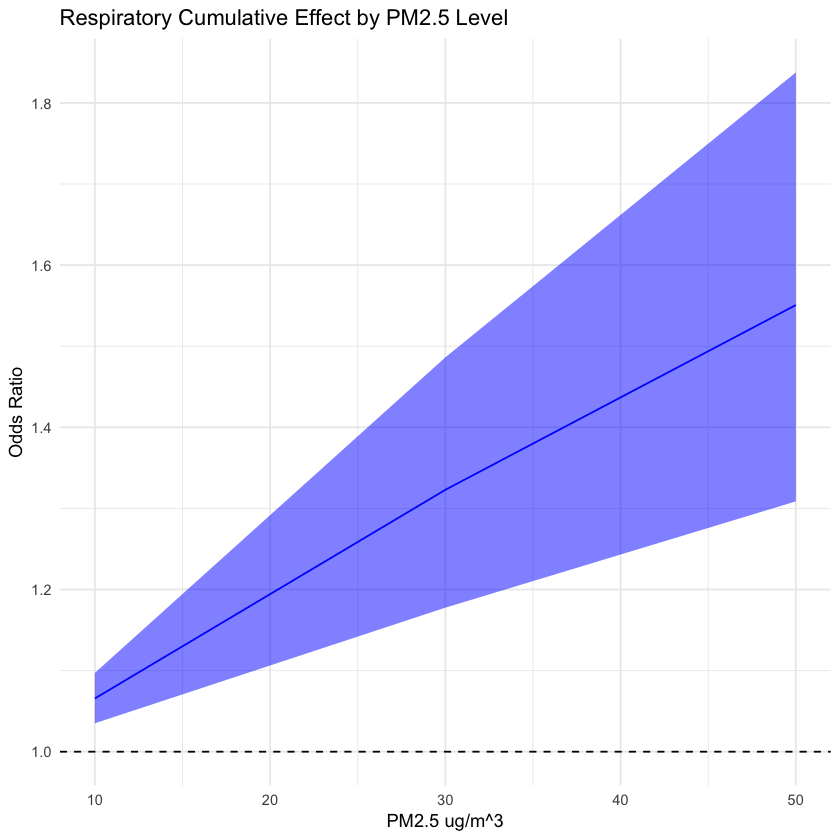

In [381]:
cumulative_plot <- tibble(cb_pred$predvar, cb_pred$allRRfit, cb_pred$allRRlow,
                          cb_pred$allRRhigh) 
# col names
names(cumulative_plot) <- c("pm_var", "odds_ratio", "lower95", "upper95")

cumulative_plot

ggplot(data=cumulative_plot, aes(x=pm_var, y=odds_ratio)) +
    geom_line(color = "blue") + 
    geom_ribbon(aes(ymin=lower95, ymax=upper95), fill = "blue", alpha = 0.5) +
    geom_hline(yintercept = 1, linetype=2) +
    ylab("Odds Ratio") +
    xlab("PM2.5 ug/m^3") +
    ggtitle("Respiratory Cumulative Effect by PM2.5 Level") +
    theme_minimal()

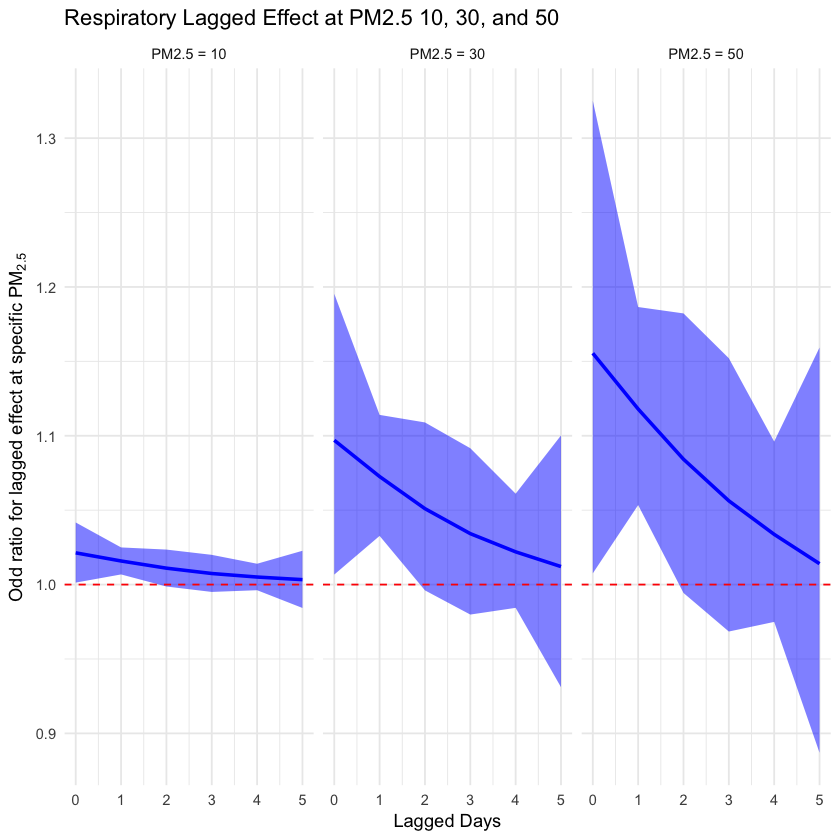

In [382]:
# distributed lag association
pm_var <- paste0("PM2.5 = ", cb_pred$predvar)

# odds ratio matrix
odds_ratio <- as.tibble(cb_pred$matRRfit) %>% 
  cbind(pm_var, .) %>% 
  gather(key = "day", value = "odds_ratio", -pm_var)
# lower 95
lower95 <- as.tibble(cb_pred$matRRlow) %>% 
  cbind(pm_var, .) %>% 
  gather(key = "day", value = "lower95", -pm_var)
# upper 95
upper95 <- as.tibble(cb_pred$matRRhigh) %>% 
  cbind(pm_var, .) %>% 
  gather(key = "day", value = "upper95", -pm_var)
# lagged est
resp_lag_est <- odds_ratio %>% 
  left_join(lower95, by = c("day", "pm_var")) %>% 
  left_join(upper95, by = c("day", "pm_var")) %>% 
  mutate(day = as.numeric(str_sub(day, start=4)))


# small-multiples dl plot
dl_plot <- ggplot(resp_lag_est, aes(x=day, y=odds_ratio)) +
  geom_line(colour = "blue", size = 1) +
  geom_ribbon(aes(ymin = lower95, ymax = upper95), 
              fill = "blue", alpha = 0.5) + 
  scale_x_continuous(breaks = c(seq(0,7, by=1))) +
  geom_hline(yintercept = 1, linetype = 2, colour = "red") +
  facet_wrap(~pm_var) +
  ylab(expression("Odd ratio for lagged effect at specific PM"[2.5])) +
  xlab("Lagged Days") +
  ggtitle("Respiratory Lagged Effect at PM2.5 10, 30, and 50")+
  theme_minimal()

dl_plot

### Association between PM<sub>2.5</sub> and Cardiovascular ED/Urgent Care 

Following same process for CVD.

In [383]:
# pm lag matrix
pm_lag_mat <- cvd %>% 
    select(contains("geo_wt_pm")) %>% 
    as.matrix() 

head(pm_lag_mat)

geo_wt_pm,geo_wt_pm_lag1,geo_wt_pm_lag2,geo_wt_pm_lag3,geo_wt_pm_lag4,geo_wt_pm_lag5
15.557,14.364,10.988,6.688,7.011,16.887
8.473,6.982,3.883,9.931,8.886,8.066
5.168,3.640,3.490,3.753,5.089,8.061
4.579,4.644,5.574,3.865,4.447,8.563
8.068,8.276,9.797,8.426,6.943,6.743
10.933,12.200,11.561,9.174,6.260,4.969


Setting up cross-basis of PM2.5 and lagged structure.

In [401]:
# crossbasis of pm
cb_pm <- crossbasis(pm_lag_mat, argvar = list(fun="ns", df = 2), lag = 5, 
                    arglag = list(fun="ns", knots = 2.5, intercept = T))

Running model with cross-basis fuction.

In [402]:
# clogit model
cvd_dl_mod <- clogit(outcome ~ cb_pm + temp_f + strata(PATIENTID), data = cvd)

In [403]:
BIC(cvd_dl_mod)

[1] 96936.31

Predicting response at PM values of 10, 30, and 50 ug/m<sup>3</sup>.

In [409]:
# cross-basis prediction 
cb_pred <- crosspred(basis = cb_pm, model = cvd_dl_mod, cen = 0, at = seq(10, 50, 20))

pm_var,odds_ratio,lower95,upper95
10,0.9751079,0.9304596,1.021899
30,0.9412827,0.8393721,1.055566
50,0.9268253,0.7931931,1.082971


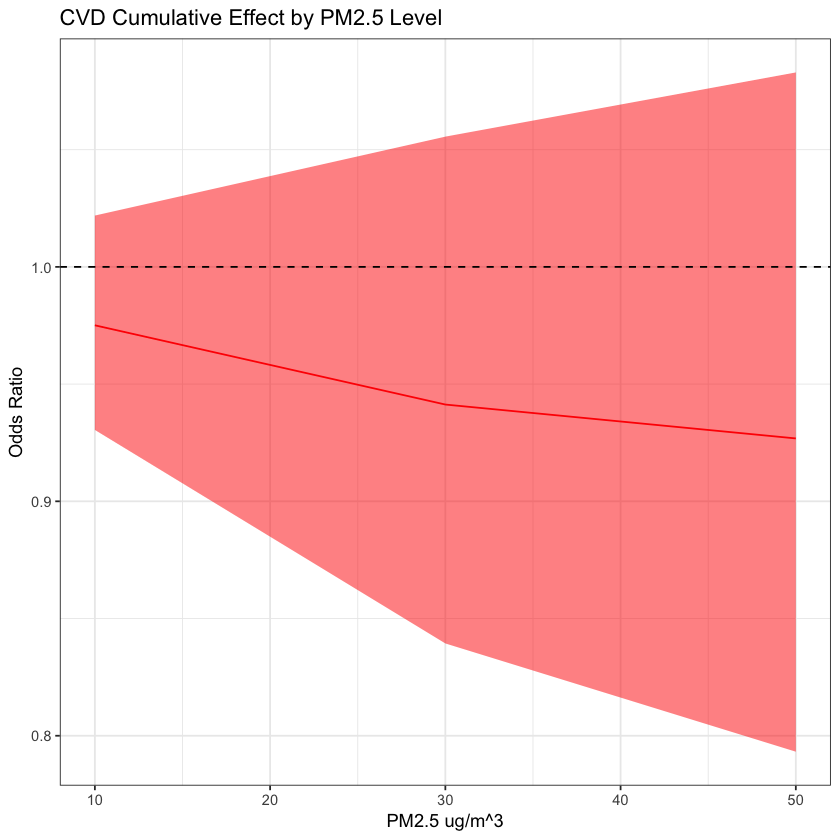

In [410]:
cumulative_plot <- tibble(cb_pred$predvar, cb_pred$allRRfit, cb_pred$allRRlow,
                          cb_pred$allRRhigh) 
# col names
names(cumulative_plot) <- c("pm_var", "odds_ratio", "lower95", "upper95")

cumulative_plot

ggplot(data=cumulative_plot, aes(x=pm_var, y=odds_ratio)) +
  geom_line(color = "red") + 
  geom_ribbon(aes(ymin=lower95, ymax=upper95), fill = "red", alpha = 0.5) +
  geom_hline(yintercept = 1, linetype=2) +
  ylab("Odds Ratio") + 
  xlab("PM2.5 ug/m^3") +
  ggtitle("CVD Cumulative Effect by PM2.5 Level") +
  theme_bw()

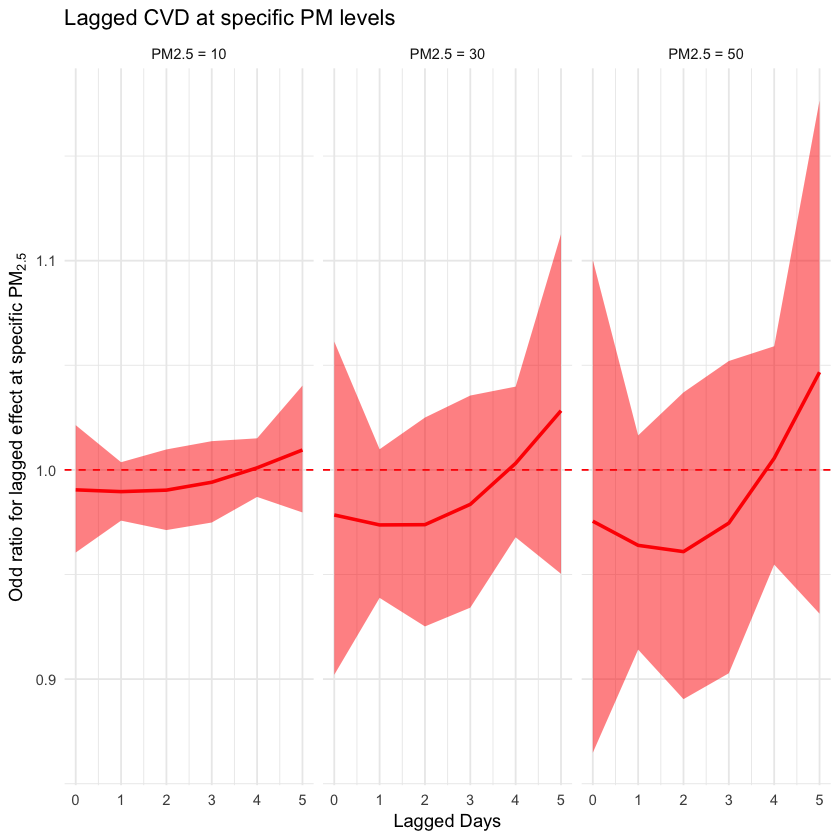

In [413]:
# distributed lag association
pm_var <- paste0("PM2.5 = ", cb_pred$predvar)

# odds ratio matrix
odds_ratio <- as.tibble(cb_pred$matRRfit) %>% 
  cbind(pm_var, .) %>% 
  gather(key = "day", value = "odds_ratio", -pm_var)
# lower 95
lower95 <- as.tibble(cb_pred$matRRlow) %>% 
  cbind(pm_var, .) %>% 
  gather(key = "day", value = "lower95", -pm_var)
# upper 95
upper95 <- as.tibble(cb_pred$matRRhigh) %>% 
  cbind(pm_var, .) %>% 
  gather(key = "day", value = "upper95", -pm_var)
# lagged est
cvd_lag_est <- odds_ratio %>% 
  left_join(lower95, by = c("day", "pm_var")) %>% 
  left_join(upper95, by = c("day", "pm_var")) %>% 
  mutate(day = as.numeric(str_sub(day, start=4)))


# small-multiples dl plot
dl_plot <- ggplot(cvd_lag_est, aes(x=day, y=odds_ratio)) +
  geom_line(colour = "red", size = 1) +
  geom_ribbon(aes(ymin = lower95, ymax = upper95), 
              fill = "red", alpha = 0.5) + 
  scale_x_continuous(breaks = c(seq(0,7, by=1))) +
  geom_hline(yintercept = 1, linetype = 2, colour = "red") +
  facet_wrap(~pm_var) +
  ylab(expression("Odd ratio for lagged effect at specific PM"[2.5])) +
  xlab("Lagged Days") +
  ggtitle("Lagged CVD at specific PM levels") +
  theme_minimal()

dl_plot

### Summary

Well looks like there is no association with CVD.